<a href="https://colab.research.google.com/github/DonghakPark/Dacon_Competition/blob/master/08_24(colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from time import time
import datetime
import gc
from scipy.signal import find_peaks, peak_widths, peak_prominences
# Model
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
import xgboost as xgb

# Ensemble
from scipy.optimize import minimize
from sklearn.metrics import log_loss

from google.colab import drive
drive.mount('/content/drvie')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drvie


In [9]:
train = pd.read_csv('/content/drvie/My Drive/Colab Notebooks/Data/train.csv')
test = pd.read_csv('/content/drvie/My Drive/Colab Notebooks//Data/test.csv')
sample_submission = pd.read_csv('/content/drvie/My Drive/Colab Notebooks/Data/sample_submission.csv')

In [10]:
train.shape

(320000, 20)

In [11]:
test.shape

(80000, 19)

In [15]:
train.head()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
0,0,23.263956,20.336773,19.009500,17.672439,16.939607,-0.000081,23.12426,20.25779,18.95512,17.63211,16.90894,18,18,1.189764,1.190681,1.188979,1.189355,1.190206,0
1,1,15.052147,14.061969,13.452418,13.268450,13.168941,0.004506,14.96642,14.00452,13.41139,13.23625,13.13468,1,1,1.253254,1.257836,1.248762,1.250997,1.255533,1
2,2,16.786385,15.825426,15.536318,15.393535,15.350032,0.000472,16.60765,15.68659,15.44004,15.32173,15.29608,2,2,1.022499,1.024105,1.020983,1.021730,1.023291,0
3,3,25.660638,21.188727,20.221158,19.894949,19.634649,0.000006,25.35365,20.99465,20.08727,19.79465,19.55518,4,3,1.205399,1.206058,1.204874,1.205120,1.205712,0
4,4,24.453429,20.699170,19.042368,18.324152,17.982649,-0.000033,23.77140,20.43384,18.86299,18.19028,17.87592,13,12,1.193946,1.194285,1.193738,1.193826,1.194099,0


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320000 entries, 0 to 319999
Data columns (total 20 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         320000 non-null  int64  
 1   u          320000 non-null  float64
 2   g          320000 non-null  float64
 3   r          320000 non-null  float64
 4   i          320000 non-null  float64
 5   z          320000 non-null  float64
 6   redshift   320000 non-null  float64
 7   dered_u    320000 non-null  float64
 8   dered_g    320000 non-null  float64
 9   dered_r    320000 non-null  float64
 10  dered_i    320000 non-null  float64
 11  dered_z    320000 non-null  float64
 12  nObserve   320000 non-null  int64  
 13  nDetect    320000 non-null  int64  
 14  airmass_u  320000 non-null  float64
 15  airmass_g  320000 non-null  float64
 16  airmass_r  320000 non-null  float64
 17  airmass_i  320000 non-null  float64
 18  airmass_z  320000 non-null  float64
 19  class      320000 non-n

In [16]:
train.isna().sum()
#결측치 확인

id           0
u            0
g            0
r            0
i            0
z            0
redshift     0
dered_u      0
dered_g      0
dered_r      0
dered_i      0
dered_z      0
nObserve     0
nDetect      0
airmass_u    0
airmass_g    0
airmass_r    0
airmass_i    0
airmass_z    0
class        0
dtype: int64

In [17]:
train.describe()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
count,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000,320000.000000
mean,159999.500000,19.852429,18.376837,17.735761,17.174226,16.875187,0.058308,19.628874,18.227087,17.615434,17.152347,16.869277,6.332700,6.138816,1.175763,1.176528,1.175131,1.175430,1.176128,1.116322
std,92376.187408,1.945548,31.110759,1.466242,52.561464,57.146264,0.575457,1.923586,17.786568,1.473020,25.075760,35.436549,8.881129,8.551634,0.116297,0.118065,0.114723,0.115485,0.117156,0.923455
min,0.000000,-17.687512,-17555.365606,7.731354,-23955.817764,-23955.817764,-166.048260,-42.837530,-9999.000000,-16.380230,-9999.000000,-9999.000000,1.000000,1.000000,1.000059,1.000012,1.000157,1.000105,1.000027,0.000000
25%,79999.750000,18.724150,17.474851,16.877190,16.523876,16.288890,0.000036,18.563598,17.348370,16.787138,16.453048,16.234063,1.000000,1.000000,1.088220,1.088448,1.087763,1.088021,1.088299,0.000000
50%,159999.500000,19.419439,18.140528,17.525850,17.149736,16.917610,0.047129,19.264635,18.022410,17.443415,17.087370,16.869390,2.000000,2.000000,1.179350,1.179235,1.179375,1.179377,1.179303,1.000000
75%,239999.250000,20.432092,19.073172,18.428089,18.007435,17.728924,0.094597,20.197603,18.888443,18.291078,17.906960,17.655653,5.000000,5.000000,1.227540,1.225990,1.229236,1.228599,1.226757,2.000000
max,319999.000000,58.623328,46.338272,72.009662,50.164052,52.612664,62.323343,30.777850,30.613170,31.957200,32.016220,30.781270,44.000000,42.000000,2.050775,2.080287,2.022134,2.036329,2.065390,2.000000


In [18]:
train['class'].nunique()

3

In [19]:
train['class'].value_counts()

2    157219
0    119996
1     42785
Name: class, dtype: int64

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

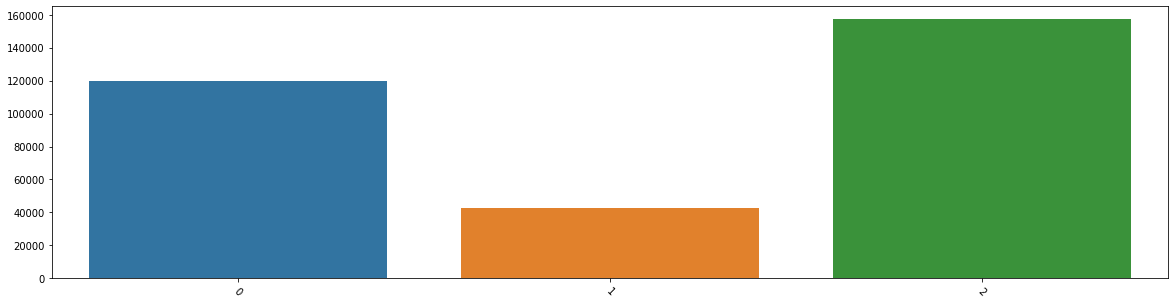

In [21]:
plt.figure(figsize=(20, 5))
sns.barplot(train['class'].value_counts().index, train['class'].value_counts().values)
plt.xticks(rotation = -45)

In [27]:
for col in train.columns[1:-1]:
    print(col)

u
g
r
i
z
redshift
dered_u
dered_g
dered_r
dered_i
dered_z
nObserve
nDetect
airmass_u
airmass_g
airmass_r
airmass_i
airmass_z


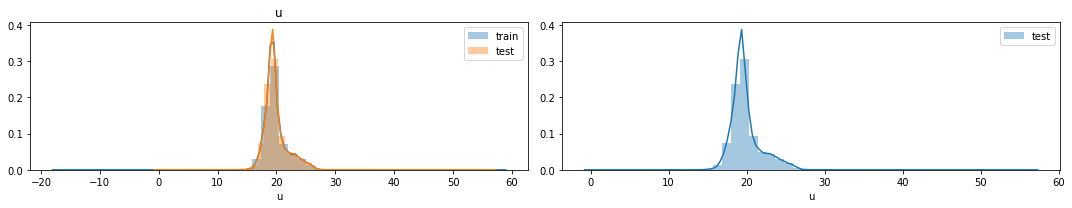

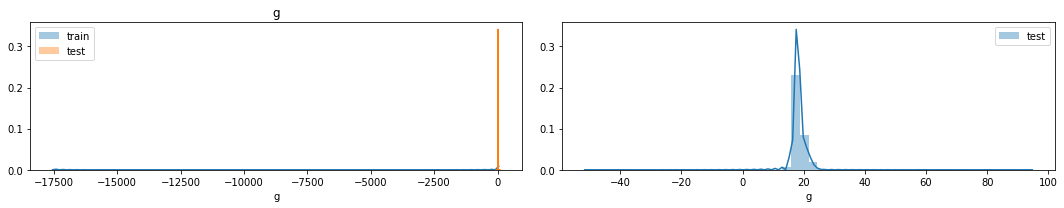

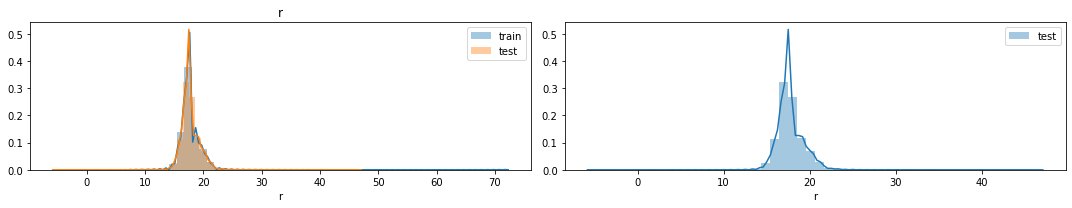

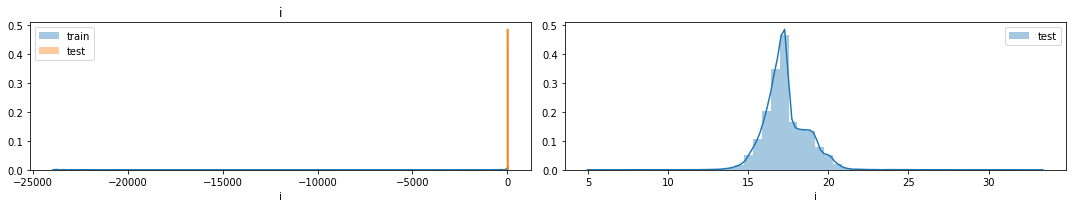

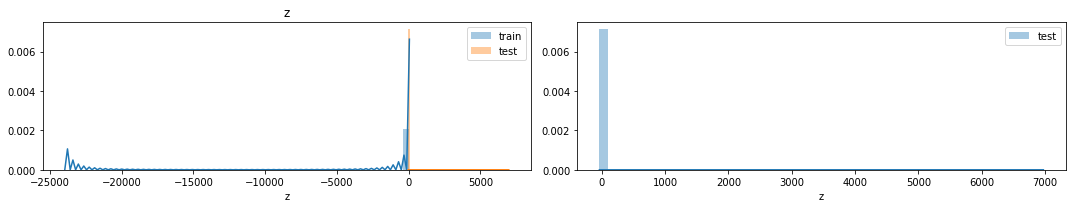

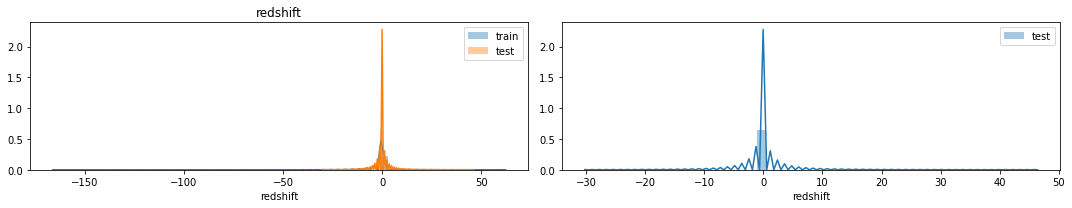

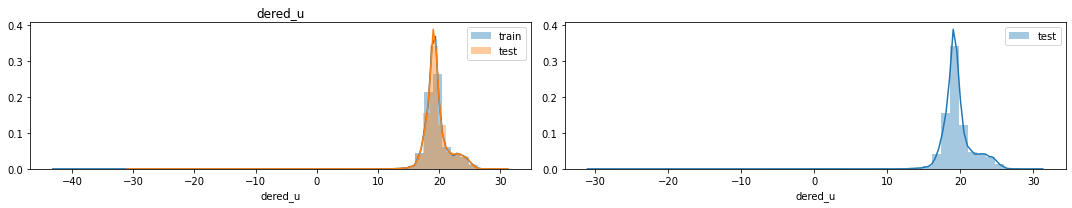

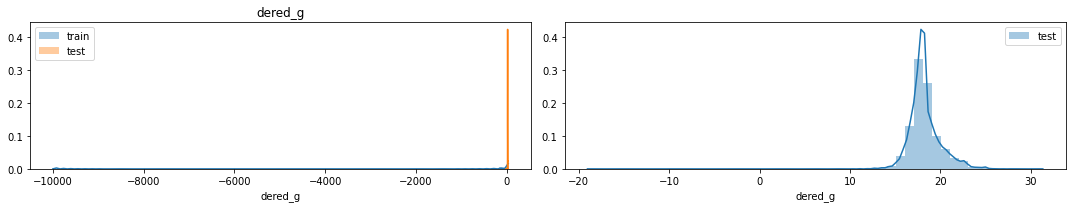

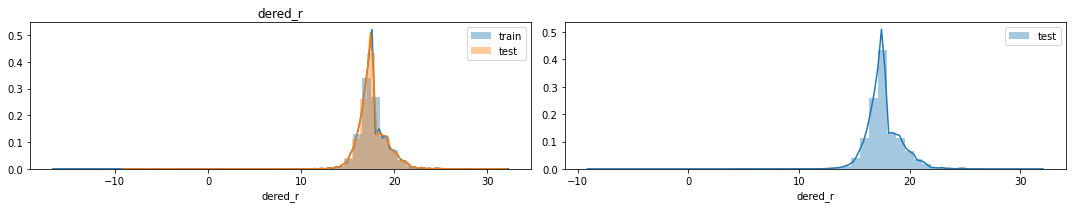

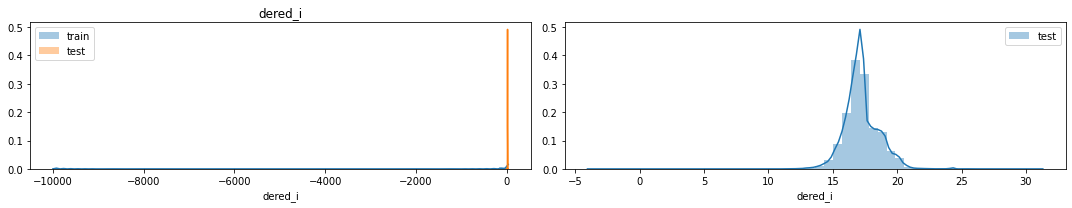

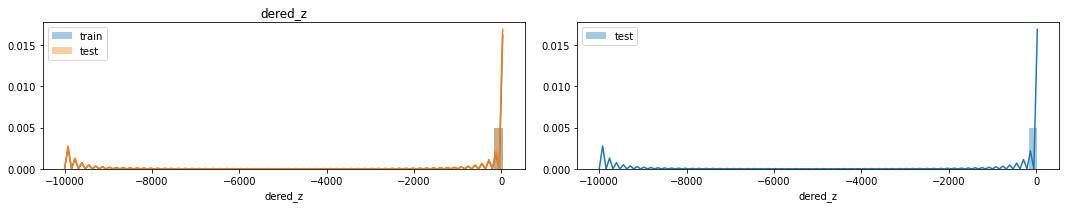

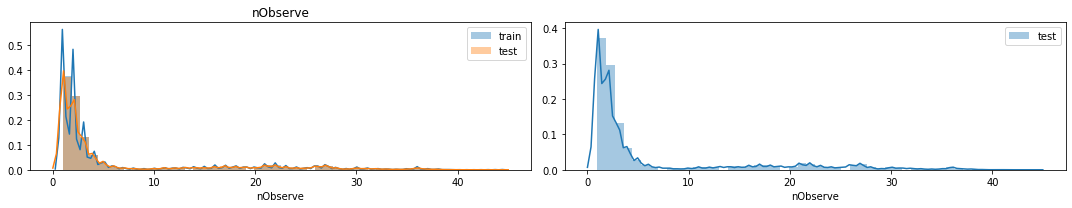

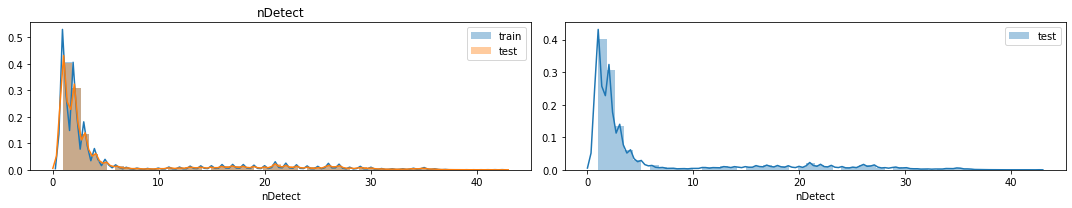

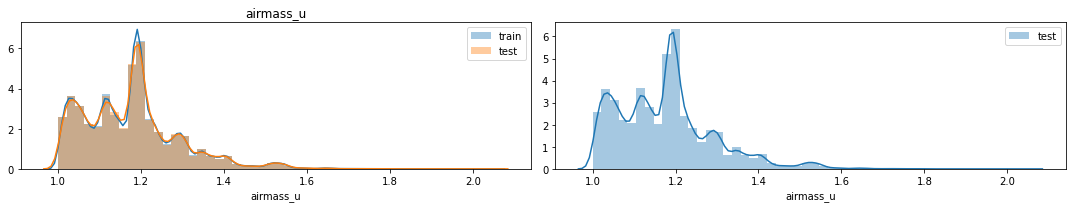

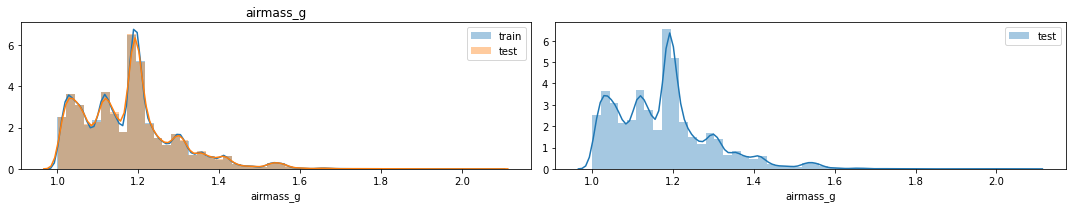

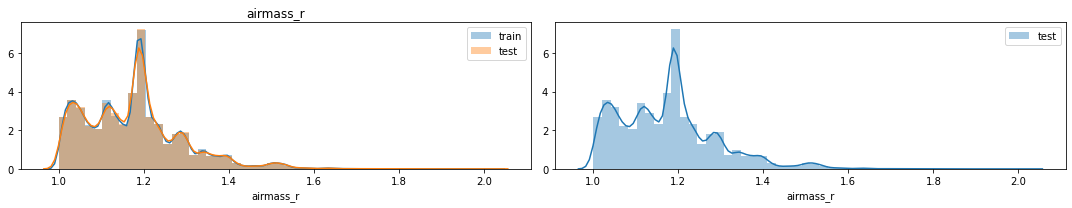

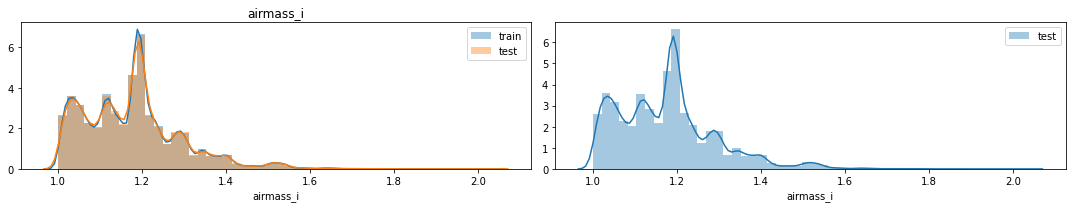

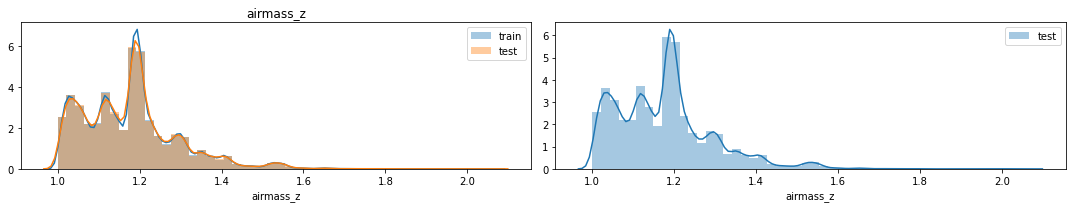

In [30]:
for col in train.columns[1:-1]:

    fig,((ax1, ax2)) = plt.subplots(1,2, figsize = (15,3))
    sns.distplot(train[col], label='train', ax=ax1)
    sns.distplot(test[col], label='test', ax=ax1)
    sns.distplot(test[col], label='test', ax=ax2)
    if col == 'fiberID':
        fig.suptitle('Handing outliers: Before vs After', fontsize=18)

    ax1.set_title(col)
    #ax2.set_title('after handling outliers')
    ax1.legend()
    ax2.legend()
    plt.tight_layout()

In [34]:
#이상치 제거

train_shape = 320000
for col in train.columns[1:-1]:
    train = train.loc[np.logical_and(train[col]>test[col].min(),
                                     train[col]<test[col].max())]
print("제거된 행 개수 :", 320000 - train.shape[0])

제거된 행 개수 : 106590


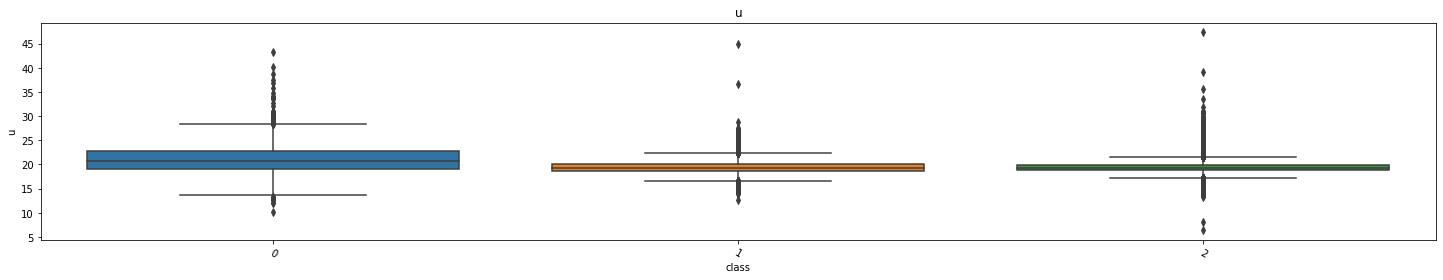

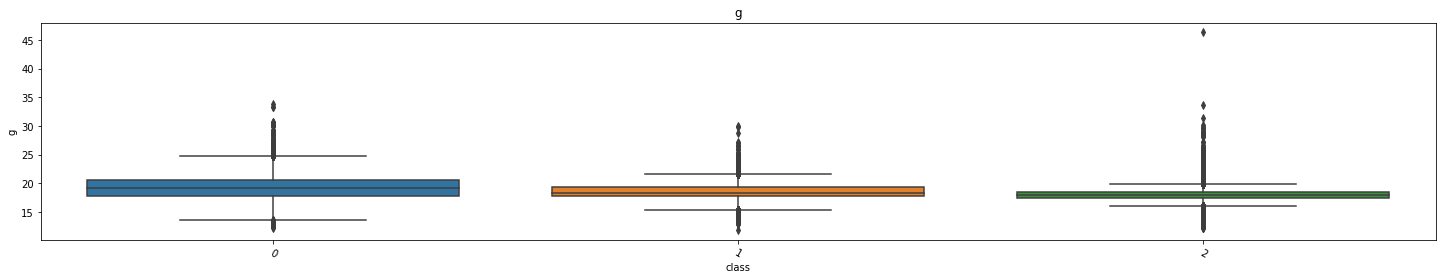

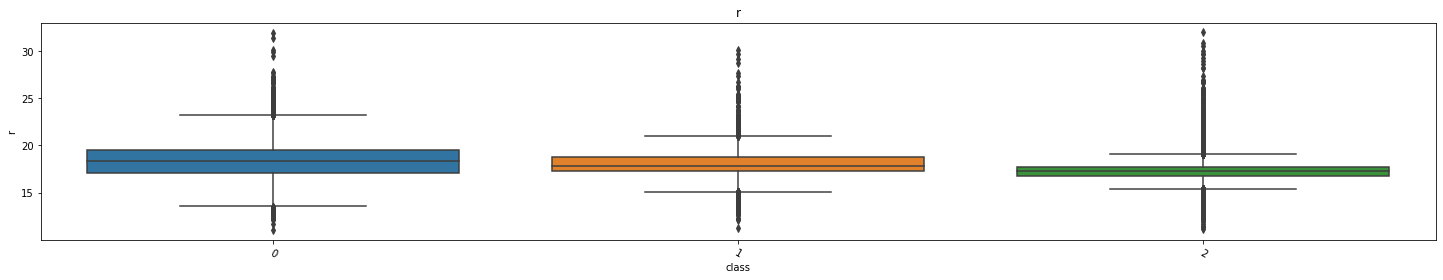

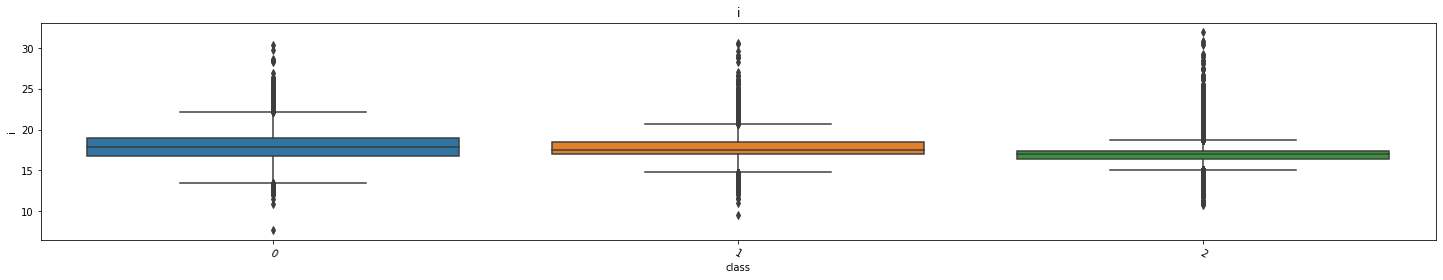

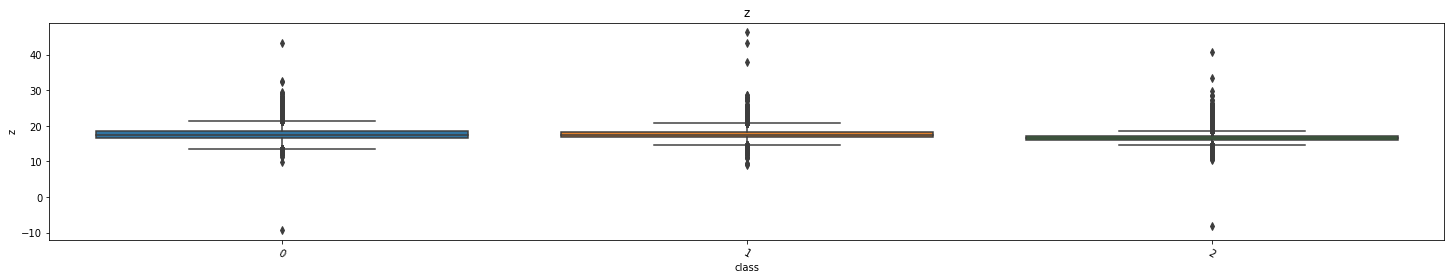

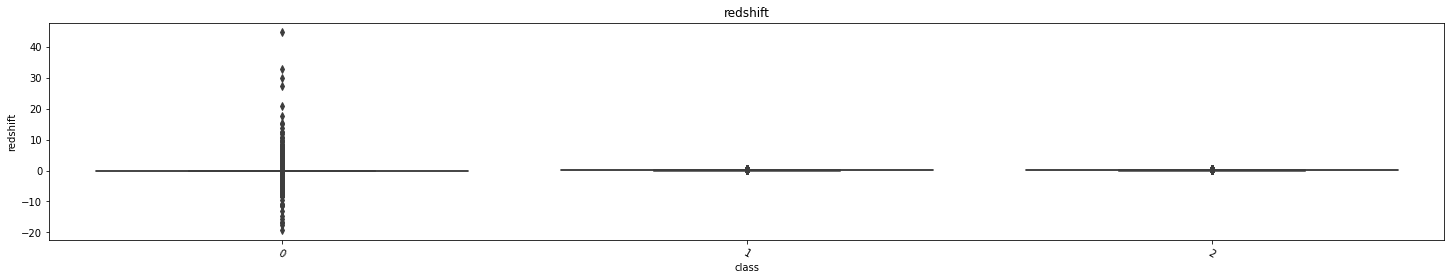

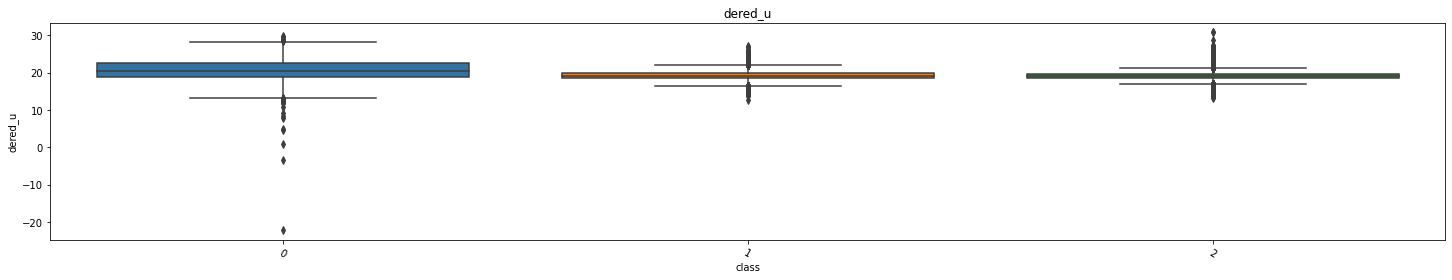

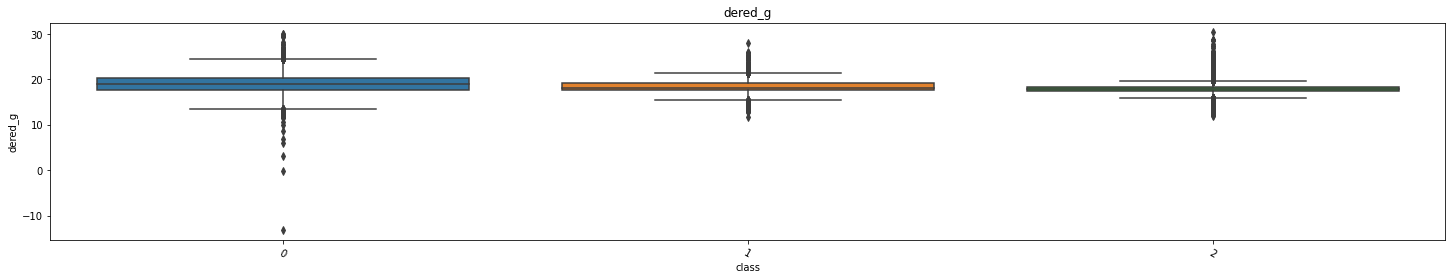

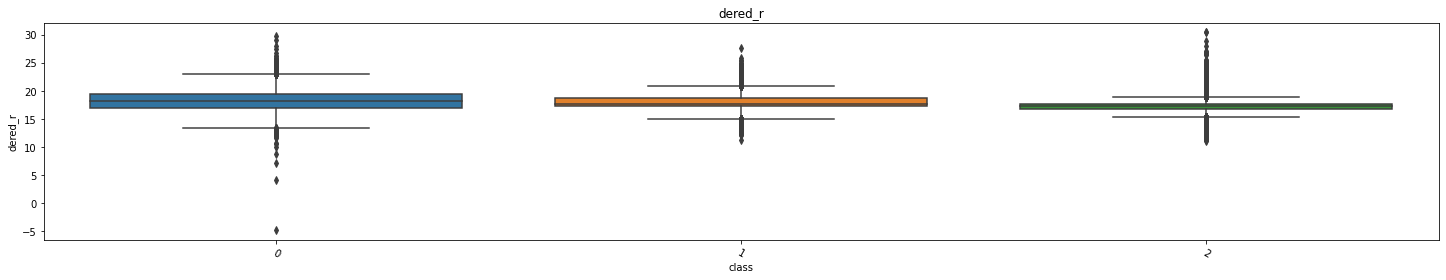

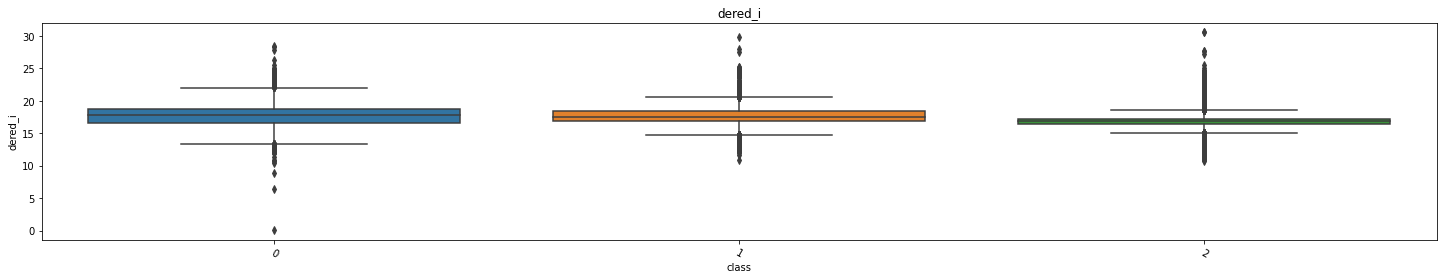

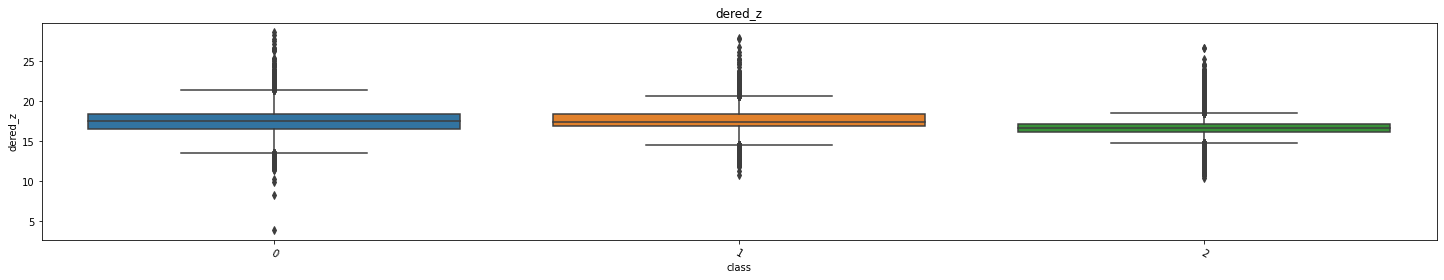

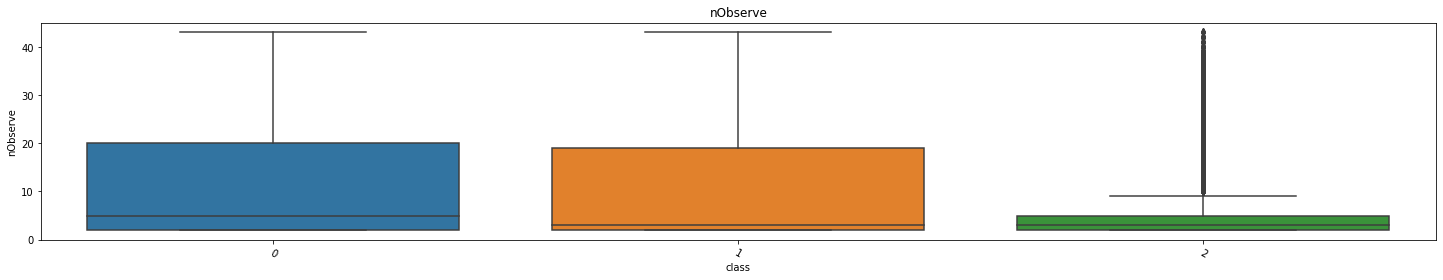

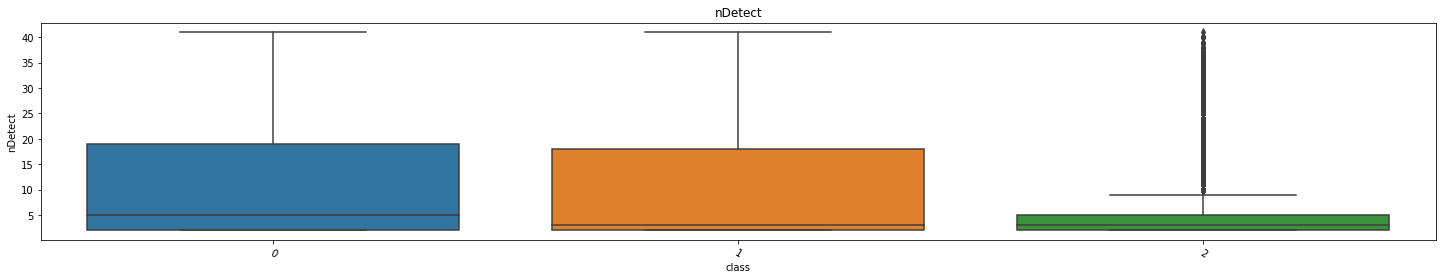

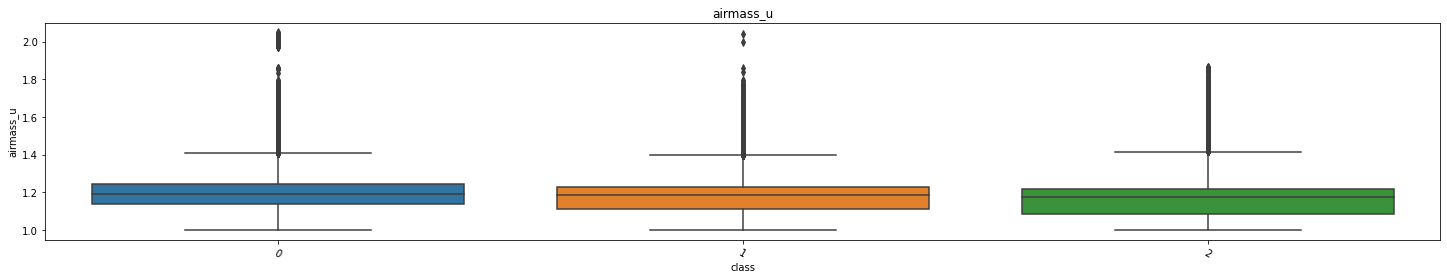

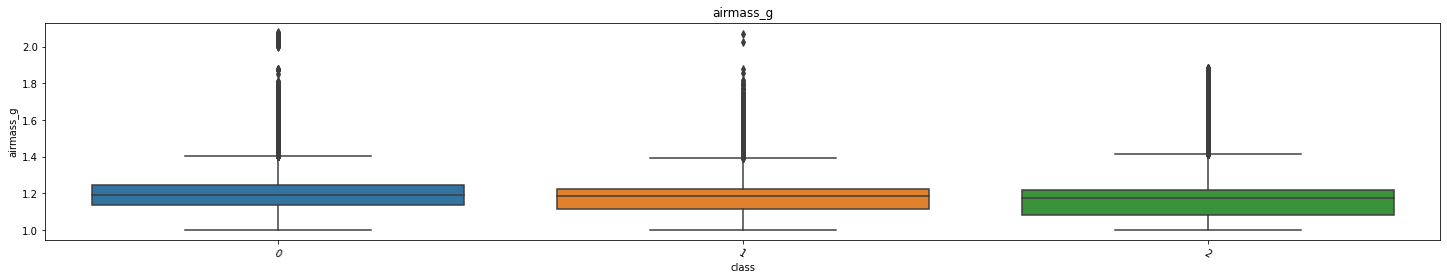

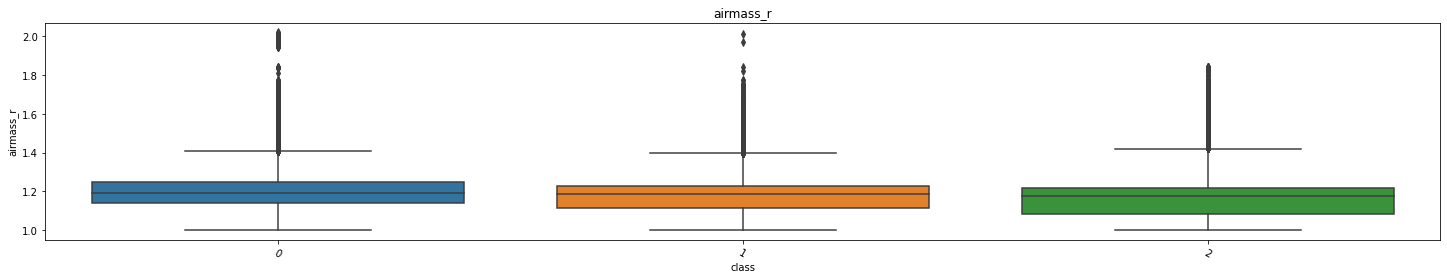

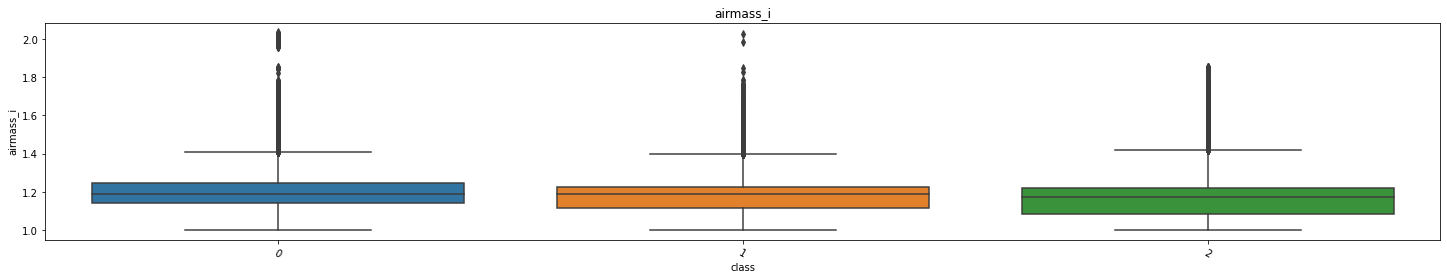

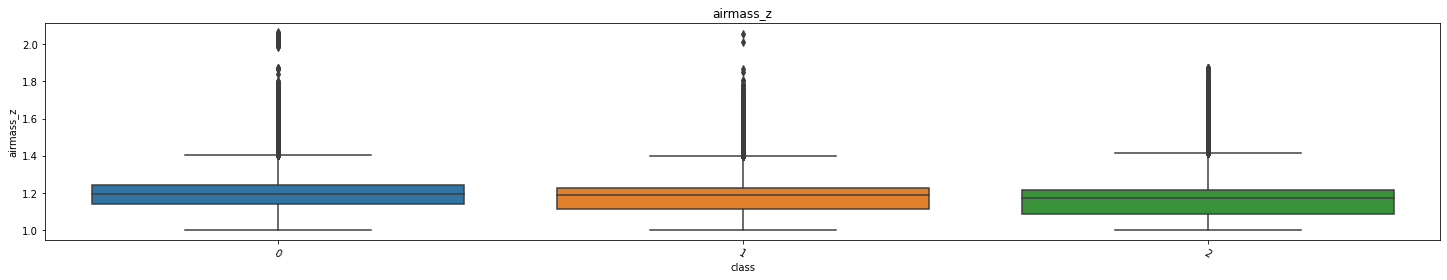

In [35]:
for col in train.columns[1:-1]:
    plt.figure(figsize=(25,4))
    sns.boxplot(x='class', y=col, data=train)
    plt.title(col)
    plt.xticks(rotation=-30)
    plt.show()

In [42]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance
%matplotlib inline



In [43]:
train = pd.read_csv('/content/drvie/My Drive/Colab Notebooks/Data/train.csv',index_col=0)
test = pd.read_csv('/content/drvie/My Drive/Colab Notebooks//Data/test.csv',index_col=0)
sample_submission = pd.read_csv('/content/drvie/My Drive/Colab Notebooks/Data/sample_submission.csv',index_col=0)

In [44]:
train_x = train.drop(columns='class', axis=1)
train_y = train['class']
test_x = test

In [45]:
forest = xgb.XGBClassifier(seed = 777,
                           learning_rate=0.005,
                           colsample_bytree=0.5232334448672797,
                           gamma=0.8661895281603577,
                           reg_alpha=3.54036580825445,
                           reg_lambda=0.10293226563406928,
                           subsample=0.7849549260809972,
                           max_depth=10,
                           tree_method='gpu_hist',
                           n_estimators=100)
forest.fit(train_x, train_y)
y_pred = np.argmax(forest.predict_proba(test_x), axis =1)

In [47]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv("/content/drvie/My Drive/Colab Notebooks/Data/xgb_submission_0824.csv", index=True)